# Heart Attack Predictive Analysis

The aim of this project is to create models that would successfully predict whether a patient is prone to having a heart attack based on a wide variety of demographics and physical factors. We take a statistical approach to feature engineering, using the nature of the distributions of each feature to select the most relevant ones to be included in the classifiers. We aim to quantize the advantge of this approach and compare our findings across classifiers with all features and with only statistically relevant features.

In [1]:
import framework as f 
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils import all_estimators
import numpy as np
import matplotlib.pyplot as plt
import scipy

## Dataset

The dataset consits of 12 different characteristics, some of which are numerical and some of which are categorical.

In [2]:
df = f.read_csv('heart.csv')

Empty DataFrame
Columns: [Age, Sex, ChestPainType, RestingBP, Cholesterol, FastingBS, RestingECG, MaxHR, ExerciseAngina, Oldpeak, ST_Slope, HeartDisease]
Index: []
Number of rows 918
number of columns  12


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
df['FastingBS'] = df['FastingBS'].astype('object')
df['HeartDisease'] = df['HeartDisease'].astype('object')

In [5]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [6]:
numerical_columns = ['Age', 'MaxHR', 'RestingBP','Oldpeak','Cholesterol']
categorical_columns = ['Sex', 'ChestPainType', 'FastingBS',
       'RestingECG','ExerciseAngina', 'ST_Slope',
       'HeartDisease']

In [7]:
numerical_columns

['Age', 'MaxHR', 'RestingBP', 'Oldpeak', 'Cholesterol']

## Univariate Analysis

### Numerical Features

We start by presenting a univariate analysis understanding the distribution of each of the numerical features by examining their distributions. The plots reveal that most of these features are approximately normally distributed with the exception of oldpeak, which has a right-skewed distribution.

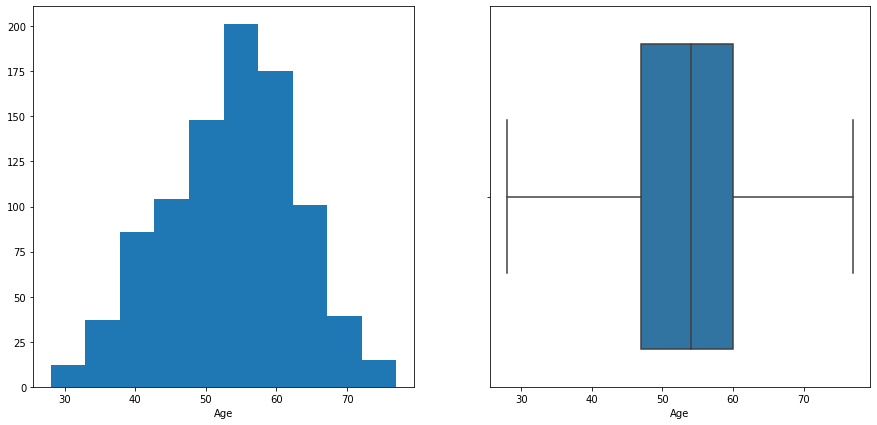

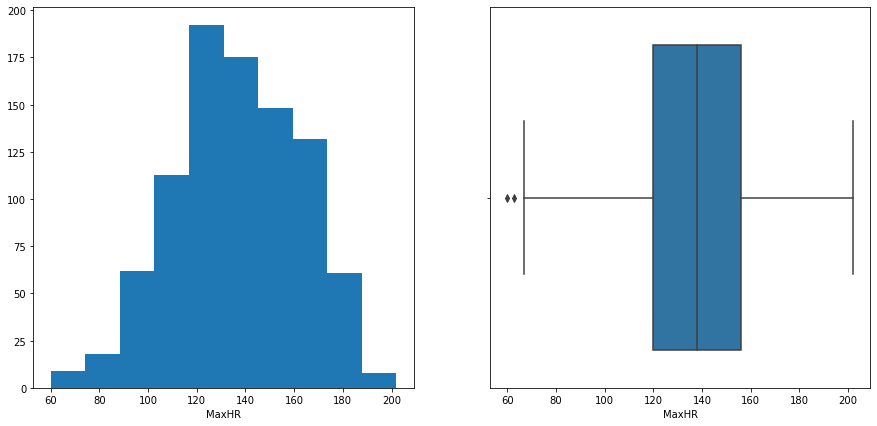

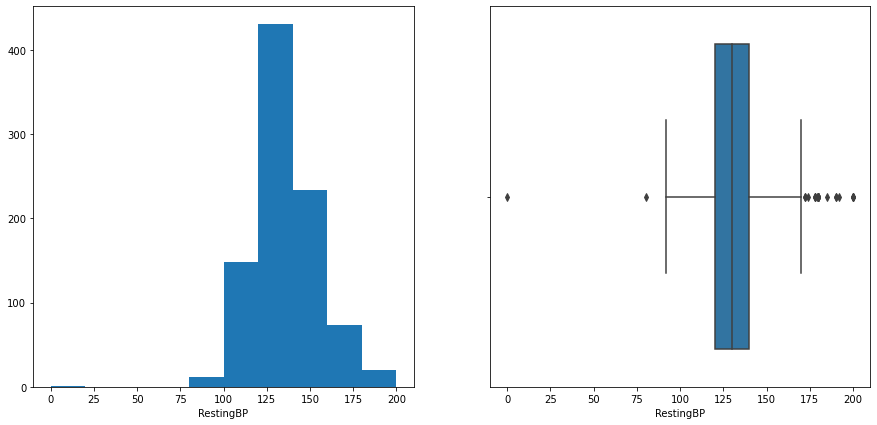

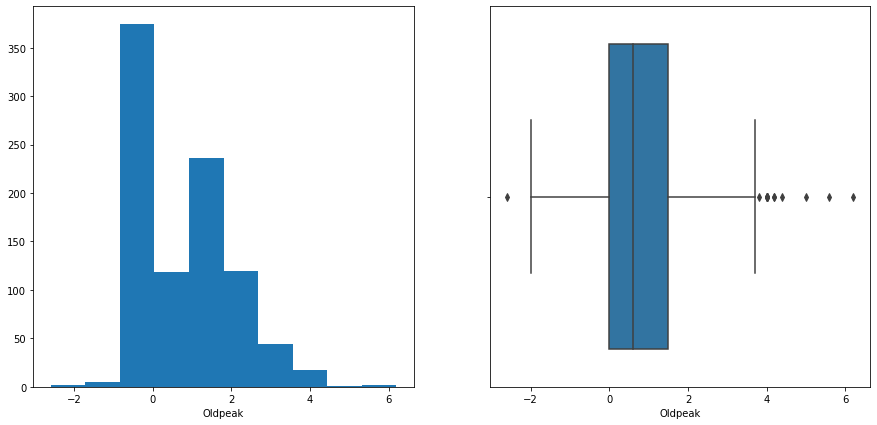

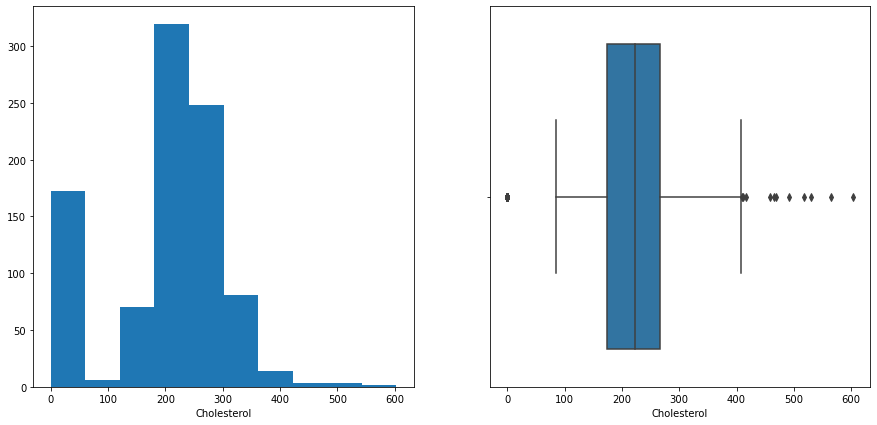

In [8]:
f.univariate_numerical_analysis(df, numerical_columns)

### Categorical Features

The categorical features have 2 or more categories across which the data can be spread. The distributions show that for some the variance between categories is quite large (e.g. FastingBS) and for some the distribution among the categories is less clear (e.g. HeeartDisease). This is to be quantified using statistical analysis lateer on in the project.

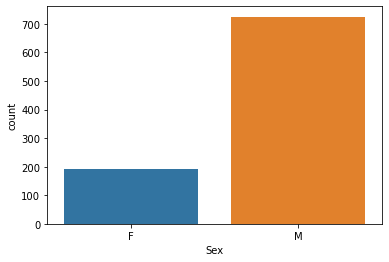

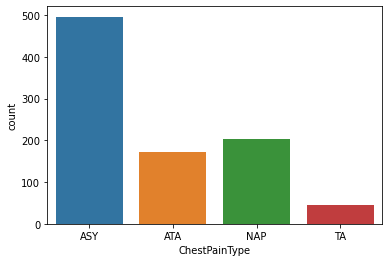

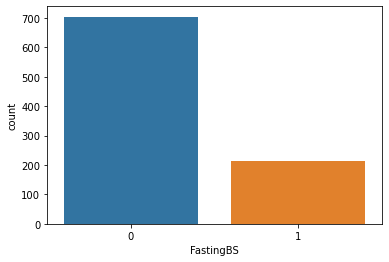

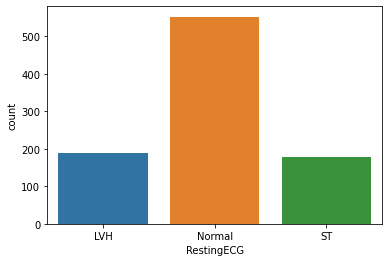

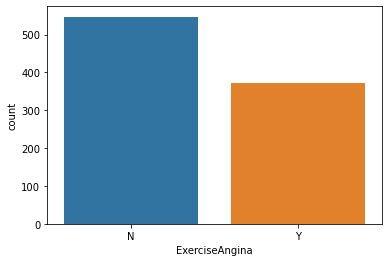

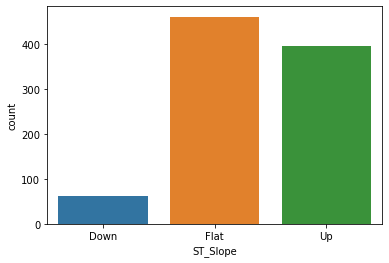

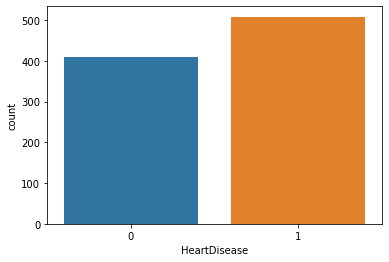

In [9]:
f.univariate_categorial_analysis(df, categorical_columns)

## Bivariate Analysis

The plots below show the distributions of each feature high and low likelihood of heart attack. The plots are shown for numerical and categorical features separately. The aim is to identify features where these distributions are significantly different. For similar distributions, it is likely that such feature might not help the classifier distinguish between these types of tumors.

A visual analysis suggest these features might be candidates for exclusion since their distributions are not easily distinguishable: Age, RestingBP, Oldpeak, Cholesterol, ChestPainType, RestingECG and ST_Slope.

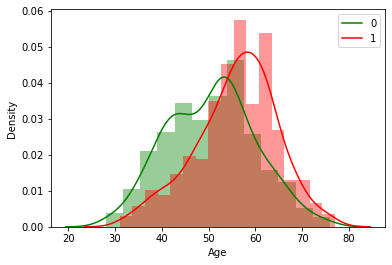

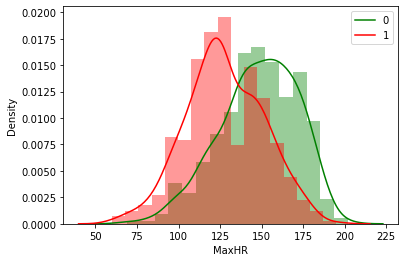

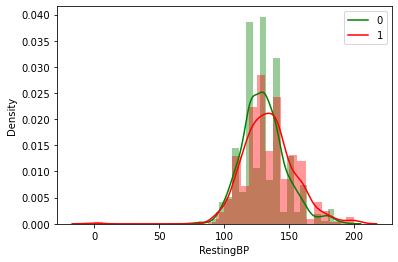

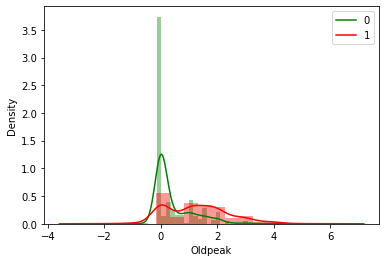

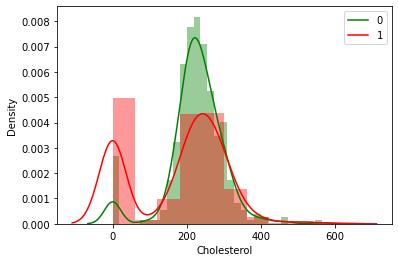

In [10]:
f.bivariate_analysis_numerical(df, numerical_columns,'HeartDisease', 0,1)

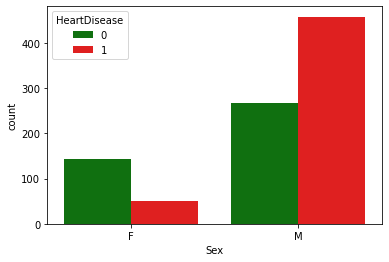

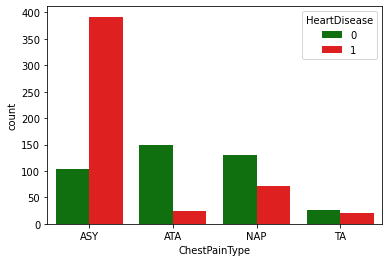

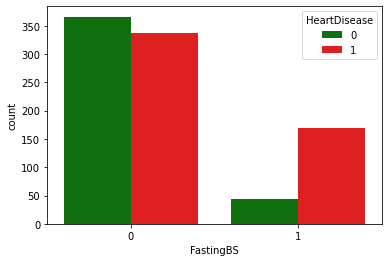

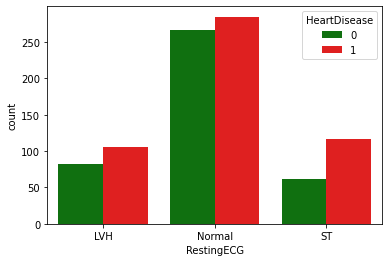

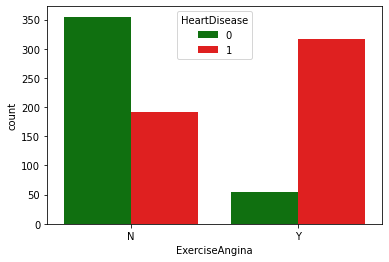

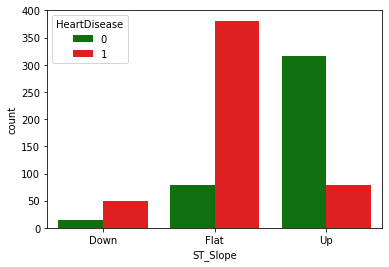

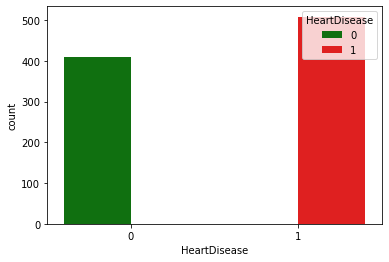

In [11]:
f.bivariate_categorial_analysis(df, categorical_columns, 'HeartDisease')

We have noticed from the bivariate analaysis and the univariate analysis of the numerical feature, 
cholestrol, has a lot of zero values.
So we decided to replace the 0 values with all the means using simple imputer. 

In [12]:
df['Cholesterol'] = SimpleImputer(missing_values = 0.0, strategy = 'mean').fit_transform(df['Cholesterol'].values.reshape(-1,1))[:,0]

We conduct a mannwhitneyu on all the numeical distributions.
We conduct a chi squared on all the categorical distributions.

H0 (null hypothesis): The means of the distributions for benign and malignant tumors are the same.

Ha (alternate hypothesis): The means of the distributions for benign and malignant tumors are different.


We want to exclude features which fail to reject the null hypothesis.

##### Statistical Testing

Note: We would generally run t-tests on the numerical variables, however, the issue is that not all the of variables follow a normal distribution, and since we do not want turn to such strong assumptions, we run the mannwhitneyu test. Theortically, we should be running the wilcoxon test; however, the problem with the wilcoxon test is that it only works if the number of samples in each of the distributions is the same. This is not the case for us hence we opt for the mannwhitheyu test.

In [13]:
print("Categorical Variables to Exclude")
for column in categorical_columns:
    f.chi_squared_test(column, df, output = 'HeartDisease')

print("Numerical Variables to Exclude")
for column in numerical_columns:
    f.mannwhitneyu(column, df, output = 'HeartDisease', output_1 = 0,output_2= 1)

Categorical Variables to Exclude
Numerical Variables to Exclude


No variables have distributions significantly different to reject the null hypothesis and hence exclude them from the feature set.

In [14]:
df = f.one_hot_encoding(df, categorical_columns[:-1])
df_stats = df.copy()
df_stats = f.power_transform(df_stats, numerical_columns)

Since to features had distributions such that we would want to exclude them from the featureset, we use Sklearn's variance threshold function to exclude all features that have a low variance. Features with a low variance do not contain enough good quality information for the classifier compared to high variance features hence we examine the effect of excluding them.

In [15]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_df_stats = sel.fit_transform(df_stats.drop('HeartDisease', axis =1))
y_df_stats = df_stats['HeartDisease'].astype(int)

## Classification

Wee explore 32 different classifiers and compare their accuracies for the reduced feature set and the complete feature set. We then take the mean score for the reduced and complete set and test whether the difference between them is statistically significant, to determine advantage of taking the statistical approach to feature selection.

It is important to note we take the classifiers as they are, with no fitting or fine tuning, and evaluate their accuracy which allows us to compare baseline models. The goal of this feature selection is to increase the baseline accuracy, not to increase the final fine-tuned accuracy, hence this approach is taken.

In [16]:
(X_train, X_test, y_train, y_test) = f.train_test_split(df.drop('HeartDisease', axis =1), df['HeartDisease'].astype(int))
(X_train_df, X_test_df, y_train_df, y_test_df) = f.train_test_split(X_df_stats, y_df_stats)

0.8464975845410627 0.7801932367149758


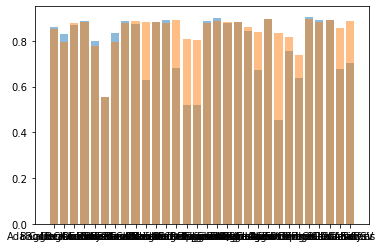

In [17]:
classifier_names_df = []
classifier_names_df_stats = []

classifier_scores_df = []
classifier_scores_df_stats = []

estimators = all_estimators(type_filter='classifier')

for name, ClassifierClass in estimators:
    try:
        classifier_names_df, classifier_scores_df = f.score(name, ClassifierClass, X_train, X_test, y_train, y_test, classifier_names_df, classifier_scores_df)
        classifier_names_df_stats, classifier_scores_df_stats = f.score(name, ClassifierClass, X_train_df, X_test_df, y_train_df, y_test_df, classifier_names_df_stats, classifier_scores_df_stats)
    except Exception as e:
        1+1
print(np.mean(classifier_scores_df_stats), np.mean(classifier_scores_df))
plt.bar(classifier_names_df,classifier_scores_df, alpha = 0.5)
plt.bar(classifier_names_df,classifier_scores_df_stats, alpha = 0.5)
plt.show()

H0: The means of the accuracy on the reduced feature set and complete feature set are the same.

Ha: The means of the accuracy on the reduced feature set and complete feature set are the same.

We can run the wilcoxon test on the following hypothesis test, because the number of samples is the same (this was unlike when we were removing the features which which were not statistically signficant). 

In [18]:
value = scipy.stats.wilcoxon(classifier_scores_df,classifier_scores_df_stats)
p_value = value[1]

print(p_value)
if abs(p_value) <= 0.1:
    print(':different means between the two groups (reject H0)')
else:
    print(':similar means between the two groups (fail to reject H0)')

0.04640922473538681
:different means between the two groups (reject H0)


## Conclusion

#### There is a statistical difference between the two algorithms

We conclude that the accuracy increases across the tested classifiers with statistical significance when passing a reduced feature seet from which all the statistically insignificant features were excluded.